# AlphaFold2-RAVE: Folding and feature selection module

In this notebook, you will start with
- A sequence, OR
- Your own ensemble of structures (short circuit the folding module)

And you will get the output of:
- Simulation box of cluster centers to initiate MD with

For details please see our preprint:

Da Teng, Vanessa J. Meraz, Akashnathan Aranganathan, Xinyu Gu, Pratyush Tiwary, AlphaFold2-RAVE: Protein Ensemble Generation with Physics-Based Sampling. ChemRxiv (2025) [10.26434/chemrxiv-2025-q3mwr](https://chemrxiv.org/engage/chemrxiv/article-details/67a3bf5f81d2151a024c36cc)

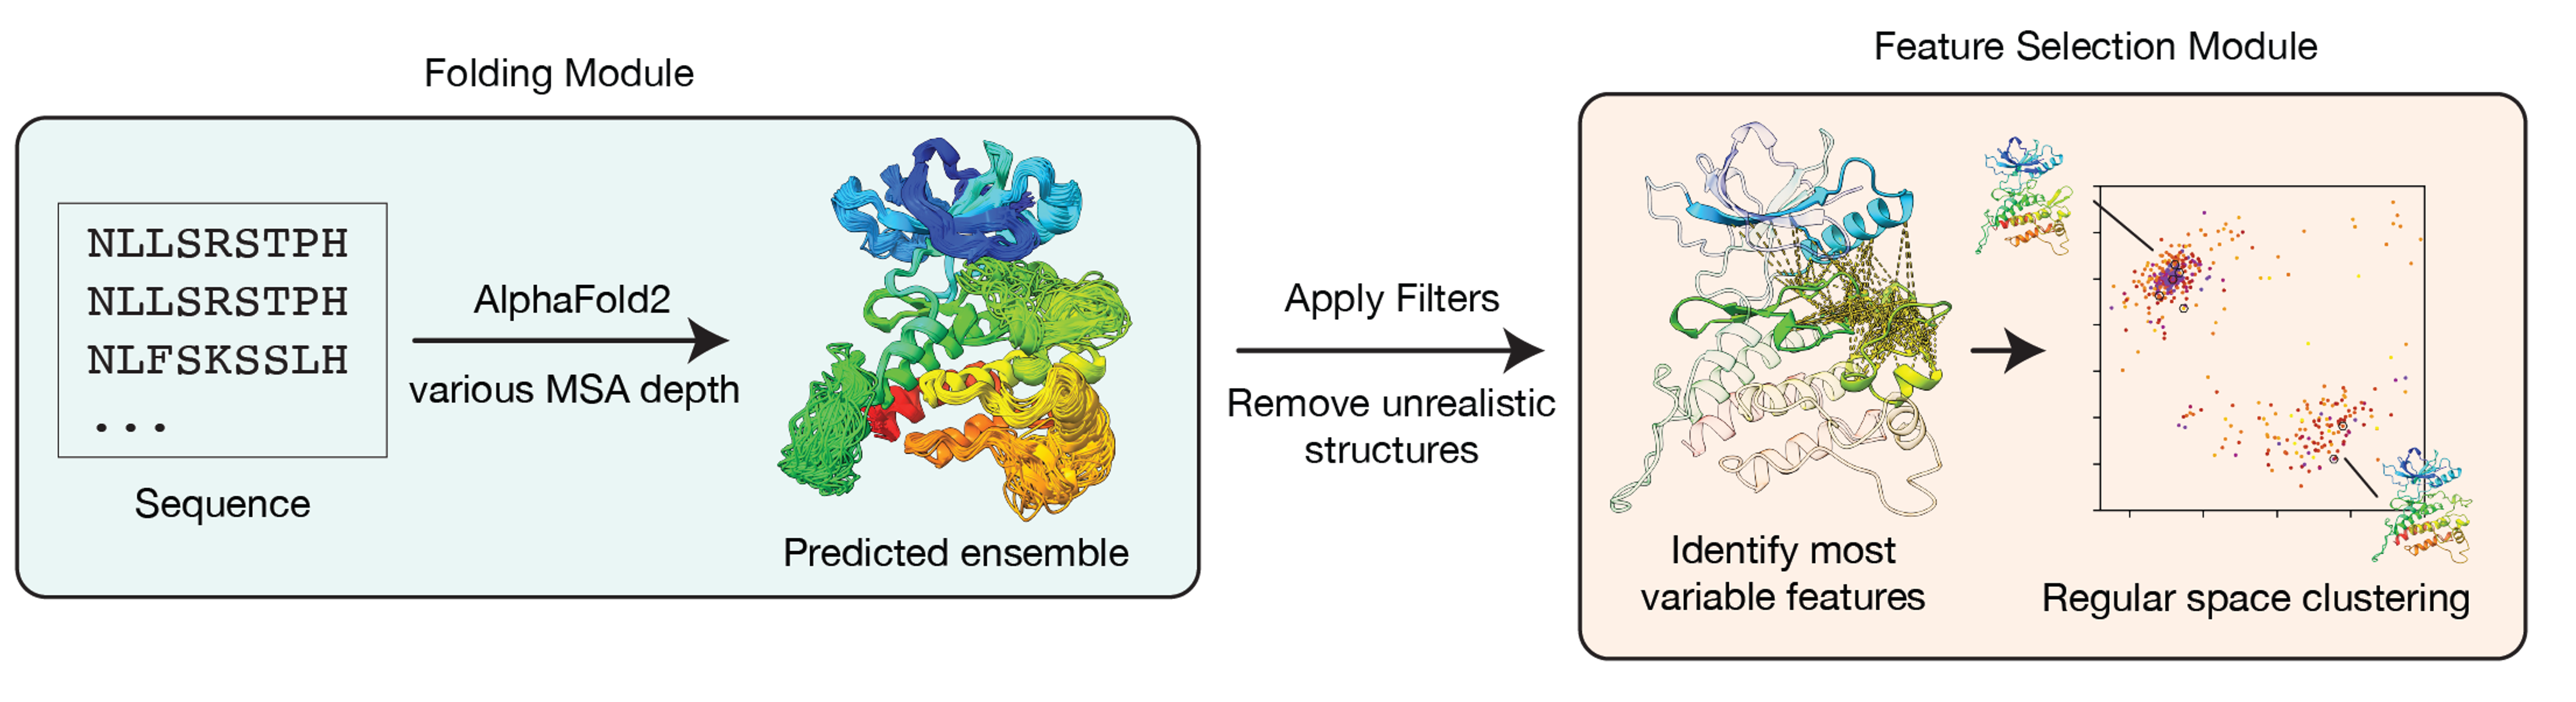

In [ ]:
#@title Folding module
!mkdir /content/colabfold
%cd /content/colabfold

import re
import hashlib
import os

#@markdown  - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer
query_sequence = 'GPPRVDFPRSRLRFKEKLGEGQFGEVHLCEVDSPQDLVSLDFPLNVRKGHPLLVAVKILRPDATKNARNDFLKEVKIMSRLKDPNIIRLLGVCVQDDPLCMITDYMENGDLNQFLSAHQLEDKAAEGAPGDGQAAQGPTISYPMLLHVAAQIASGMRYLATLNFVHRDLATRNCLVGENFTIKIADFGMSRNLYAGDYYRVQGRAVLPIRWMAWECILMGKFTTASDVWAFGVTLWEVLMLCRAQPFGQLTDEQVIENAGEFFRDQGRQVYLSRPPACPQGLYELMLRCWSRESEQRPPFSQLHRFLAEDALNTV' #@param {type:"string"}
#@markdown  - Choose `max_msa_cluster:max_extra_msa` to reduce the length of MSA used in initialization of AF2 (prescribed 16:32 and/or 8:16)
max_msa = "8:16" #@param ["1024:2048", "512:1024", "256:512","128:256", "64:128", "32:64", "16:32","8:16","4:8", "2:4","1:2"]
#@markdown  - For a `num_seeds` value rMSA give `num_seeds*5` structures (For playing around we recommend 16, and for production runs, more than 128)
num_seeds = 32 #@param [4,8,16,32,64,128] {type:"raw"}
msa_mode = "mmseqs2"

# Initializations and creating working dir
jobname = 'test'
custom_template_path = None
use_templates = False
pair_mode = "unpaired_paired"
query_sequence = "".join(query_sequence.split())
basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
model_type = "auto"
num_recycles = 1
recycle_early_stop_tolerance = None
relax_max_iterations = 200
pairing_strategy = "greedy"
use_dropout = True
save_all = True
save_recycles = False
save_to_google_drive = False
dpi = 200
def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]
jobname = add_hash(basejobname, query_sequence)
# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"
os.makedirs(jobname, exist_ok=True)

#save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

# MSA decision
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")
else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))



In [ ]:
#@markdown Code installation and Folding

#@markdown This block installs colabfold and runs the prediction

%%time
from google.colab import files
import matplotlib.pyplot as plt
import random

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

USE_AMBER = False
USE_TEMPLATES = "none"
PYTHON_VERSION = python_version

try:
  import af2rave
except ImportError:
  print("installing af2rave...")
  os.system("pip install git+https://github.com/tiwarylab/af2rave.git@installation")

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  os.system("pip install --upgrade dm-haiku")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  # patch for jax > 0.3.25
  os.system("sed -i 's/weights = jax.nn.softmax(logits)/logits=jnp.clip(logits,-1e8,1e8);weights=jax.nn.softmax(logits)/g' alphafold/model/modules.py")
  os.system("touch COLABFOLD_READY")

display_images = True

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2


try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path

def input_features_callback(input_features):
  plot_msa_v2(input_features)
  plt.show()
  plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if False:
    fig = plot_protein(protein_obj, Ls=length, dpi=150)
    plt.show()
    plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
if not os.path.isfile(log_filename) or 'logging_setup' not in globals():
  setup_logging(Path(log_filename))
  logging_setup = True

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True
num_relax=0
download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
)


## save the results
os.chdir('/content/colabfold/')
if not os.path.isdir('/content/structures'):
  os.mkdir('/content/structures')
else:
  print('Already exists!!!')
  os.system('mv /content/structures /content/backup')
  os.mkdir('/content/structures')

for i in range(num_seeds*5):
  tag = results["rank"][0][i]
  jobname_prefix = ".custom" if msa_mode == "custom" else ""
  pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
  json_filename = f"{jobname}/{jobname}{jobname_prefix}_scores_{tag}.json"
  os.system(f'cp {pdb_filename} /content/structures/pred_{i+1}.pdb')
  os.system(f'cp {json_filename} /content/structures/pred_{i+1}.json')
os.system(f'cp {jobname}/config.json /content/structures/.')
os.system(f'cp {jobname}/{jobname}.a3m /content/structures/msa.a3m')
os.system(f'rm -r {jobname}')
os.chdir('/content/')
os.system('zip -r structures.zip structures')

print('All structures are saved in `/content/structures.zip`')
colabfold_finished = True

In [ ]:
#@markdown ## Structure statistics
#@title Feature Selection module

if "colabfold_finished" in locals() and colabfold_finished:
  structures = "/content/structures"
else:
  from google.colab import files
  from natsort import natsorted
  structures = natsorted(files.upload())

try:
  # if folding module was skipped
  import af2rave.feature as af2feature
except ImportError:
  print("installing af2rave...")
  os.system("pip install git+https://github.com/tiwarylab/af2rave.git@installation")
  import af2rave.feature as af2feature

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"figure.dpi": 120})

rMSA = af2feature.FeatureSelection(structures)

fig, axes = plt.subplots(figsize=(6,4), nrows=2, ncols=2, tight_layout=True)
title = ["CA RMSD to ref",
         "Nearest heavy atom distance",
         "Peptide bond length mean",
         "Peptide bond length std"]

for ax, t in zip(axes.flatten(), title):
  ax.set_title(t)

rmsd = np.array(list(rMSA.get_rmsd("name CA").values()))
_ = axes[0,0].hist(rmsd, bins=20)
_ = axes[0,0].axvline(x=6, color="r", linestyle="--")

steric_clash = np.array([r for _, r in rMSA.minimum_nonbonded_distance.items()])
_ = axes[0,1].hist(steric_clash, bins=20)
_ = axes[0,1].axvline(x=1.0, color="r", linestyle="--")

pb_stats = rMSA.peptide_bond_stats
mean = np.array([pb_stats[x][0] for x in pb_stats])
std = np.array([pb_stats[x][1] for x in pb_stats])
_ = axes[1,0].hist(mean, bins=20)
_ = axes[1,0].axvline(x=1.4, color="r", linestyle="--")
_ = axes[1,1].hist(std, bins=20)
_ = axes[1,1].axvline(x=0.2, color="r", linestyle="--")

In [ ]:
#@markdown ## Filtering structures
#@markdown Given the statistics above, please choose cutoffs to screen the predictions. **Note: all units are in Angstrom.**

#@markdown Set the rmsd cutoff for the filter:
rmsd_selection = "name CA" #@param {type:"string"}
rmsd_cutoff = 10.0 #@param {type:"raw"}
#@markdown Then we add a steric clash filter to throw away structures with
#@markdown non-bonded distance smaller than a particular value
nonbonded_cutoff = 1.0 #@param {type:"raw"}
#@markdown Set the peptide bond filter.
#@markdown Any structure with a larger averge bond length than given
#@markdown and a standard deviation larger than given will be filtered out.
peptide_bond_mean  = 1.4 #@param {type:"raw"}
peptide_bond_std = 0.2 #@param {type:"raw"}



rmsd_filter = rMSA.rmsd_filter(selection=rmsd_selection,
                               rmsd_cutoff=float(rmsd_cutoff)
                               )
pb_filter = rMSA.peptide_bond_filter(float(peptide_bond_mean),
                                     float(peptide_bond_std)
                                     )
nb_filter = rMSA.steric_clash_filter(float(nonbonded_cutoff))
rMSA.apply_filter(rmsd_filter, nb_filter, pb_filter)

print(f"{len(rMSA)} structures remain.")

In [ ]:
#@markdown ## Selecting features

#@markdown Next, we choose a subset of atoms and use them to construct pairwise distances. These distances will be ranked according to their coefficient of variance and the top `n_features` will be selected as a feature. This is a very crude selection, feel free to include more.

#@markdown The choice of `selection` can be all CA atoms, but here is where your prior knowledge about a particular system may help. If you know good features or important atoms, include them in the list.


n_features = 200 #@param {type: "raw"}
selection = "(residue 53 to 82 and name CA) or (name CA and residue 162 to 225) or (name CZ and residue 187)" #@param {type: "string"}

names, cv = rMSA.rank_feature(selection=selection)

fig, ax = plt.subplots(figsize=(4, 3), tight_layout=True)

counts, _, _ = ax.hist(cv, bins=100, label=f"{len(names)}-dim", density=True)
cv_cutoff = cv[n_features]
ax.vlines(cv_cutoff, 0, np.max(counts)*0.6, color="red", linestyle="--", linewidth=1, label=f"Cutoff={cv_cutoff:.3f}")

ax.set_ylim(0, np.max(counts)*1.2)
ax.set_xlabel("Coefficient of Variation")
ax.set_ylabel("Density")
ax.set_xlim(0, 0.5)
_ = ax.legend()

#@markdown The plot will be a histogram of the CoVs for the pairwise distance between all these selected atoms and the cutoff.


In [ ]:
#@markdown ## Regular space clustering and PCA projection

#@markdown **Run this block to show projection of structures in a 2D PCA space**

#@markdown A few structures will be then picked as the representative structures (we call cluster centers).

#@markdown The distance cutoff `min_dist` controls how many cluster centers will be produced. There is no right answer to it.
#@markdown Depending on your MD capability, we will recommend a number that yields around 5-10 cluster centers.
#@markdown Heuristically, this can be set to your 0.5 * your RMSD cutoff

dist_cutoff = 5.0 #@param {"type": "number"}

center_id = rMSA.regular_space_clustering(names[:n_features], min_dist=dist_cutoff)
print(f"{center_id.shape[0]} clusters identified.")

for i in center_id:
    print(rMSA.pdb_name[i])

# Configuations for PCA
components = 2
pca, pca_result = rMSA.pca(n_components=components)

fig, ax = plt.subplots(figsize=(4, 3), layout='compressed')
rmsd = np.array(list(rMSA.get_rmsd("name CA").values()))
im = ax.scatter(pca_result[:,0], pca_result[:,1], s=5, c=rmsd, cmap="gnuplot", norm="linear", edgecolors="none", vmin=0.0, vmax=rmsd_cutoff)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
cbar = fig.colorbar(im, orientation='vertical')
cbar.set_label("RMSD from reference structure")

# cluster center in PC space
pca_cc = pca.transform(rMSA.feature_array[center_id])
ax.scatter(pca_cc[:,0], pca_cc[:,1], s=20, edgecolor="k", marker="H", facecolor="None", linewidth=0.5)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

In [ ]:
#@title ## Creating simulation boxes

#@markdown **Run this block to create the simulation boxes for selected cluster centers**

#@markdown The results will be in `/content/simulation_boxes`. The units are molar and Angstrom.

import af2rave.simulation as af2sim

pH = 7.0 #@param {"type": "number"}
water_padding = 10 #@param {"type": "number"}
cation = "Na+" #@param ['Cs+', 'K+', 'Li+', 'Na+', 'Rb+'] {"type": "string"}
anion = "Cl-" #@param ['Cl-', 'Br-', 'F-', 'I-'] {"type": "string"}
molar = 0.0 #@param {"type": "number"}
water_model = "tip3p" #@param {"type": "string"}

index = None
pdb_names = [rMSA.pdb_name[i] for i in center_id]

os.system("rm -rf /content/simulation_boxes")
os.system("mkdir /content/simulation_boxes")
for i in pdb_names:
    prefix = i.split("/")[-1]
    box = af2sim.SimulationBox(i)
    box.create_box(pH=pH,
                   padding=water_padding,
                   watr_model=water_model,
                   positiveIon=cation,
                   nagetiveIon=anion,
                   ionicStrength=molar
      )
    box.save_pdb(f"/content/simulation_boxes/boxed_{prefix}")

    new_index = box.map_atom_index([tuple(rMSA.atom_pairs[n]) for n in names[:200]])
    if index is None:
        index = new_index
        np.save("/content/simulation_boxes/index.npy", index)
    else:
        assert np.equal(index, new_index).all()